<a href="https://colab.research.google.com/github/Shi-raishi/Research/blob/main/pt1__data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ①foodシートの食品変数MILK1～SAKE6までの摂取量<br>
## 分析前にnutrシートにある変数EER, EN から求まるエネルギー補正係数(EER/EN) をかける<br>

### BMIメモ<br>
18.5未満	痩せ 鉄欠乏などの栄養不良による貧血のリスク<br>
18.5～25	普通 22のときが標準体重で、最も病気になりにくい<br>
25～30	肥満レベル1 25を超えると、脂質異常症や糖尿病、高血圧などの生活習慣病のリスクが2倍以上<br>
30～35	肥満レベル2 30を超えると高度な肥満として、より積極的な減量治療が必要<br>
35～40	肥満レベル3<br>
40～	肥満レベル4<br>

＊IDの重複削除とデータの結合、ECF,BMIの作成と欠損処理、異常値確認、LiNGAM

In [1]:
# Google Colabにlingamのライブラリをインストールする
# !pip install numpy
# !pip install numpy==1.24.3
!pip install numpy
!pip install lingam

In [2]:
import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_dot
from lingam.utils import print_causal_directions, print_dagc
import matplotlib.pyplot as plt
import seaborn as sns
print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.26.2', '1.5.3', '0.20.1', '1.8.2']


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/'Colab Notebooks'
%ls CSV

/content/drive/MyDrive/Colab Notebooks
'BDHQ フォーマット LongDataSet (f_nutr1).csv'
'BDHQ フォーマット LongDataSet (nutr).csv'
'BDHQ フォーマット LongDataSet (signal).csv'
'BDHQ 児童生徒用フォーマット LongDataSet (food2).csv'
'BDHQ 成人用フォーマット LongDataSet (food).csv'
 Shift-JISに変換したもの/


In [5]:
def corrMatrix(df):
  # 相関行列の作成
  corr_matrix = df.corr()

  # 高い相関を持つ変数ペアの抽出
  threshold = 0.5  # 閾値を設定
  high_corr_var = [(column, index, corr_matrix[column][index]) for column in corr_matrix.columns for index in corr_matrix.columns if (corr_matrix[column][index] > threshold) & (column != index)]
  for var_pair in high_corr_var:
      print(var_pair)

  # # 特定の変数と他の変数との相関を確認
  # target_variable = 'VEG3'
  # correlations = values_dataframe.corrwith(values_dataframe[target_variable])
  # correlations.sort_values(ascending=False)

In [6]:
def heatMap(df):
  # 相関関係の可視化
  plt.figure(figsize=(15, 15))
  sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
  plt.show()

In [7]:
def distribution(df):
  # 個々の変数の分布を確認
  for column in df.columns:
      plt.figure()
      sns.histplot(df[column], kde=True)
      plt.title(column)
      plt.show()

In [8]:
def countAvairableVariable(df):
  # 0が含まれる数をカウント
  zero_counts = (df == 0).sum().sort_values()

  # グラフのサイズを設定
  plt.figure(figsize=(12, 9))

  # 棒グラフの作成
  sns.barplot(x=len(df)-zero_counts.values, y=zero_counts.index)

  # グラフのタイトルとラベルを設定
  plt.title('Number of non-zero data in each variable')
  plt.xlabel('number of non-zero data')
  plt.ylabel('variable name')

  # グラフの表示
  plt.show()

In [9]:
def countZeroData(df):
  # 0が含まれる数を確認
  # 各変数における0の数をカウントし、少ない順にソート
  zero_counts_sorted = (df == 0).sum().sort_values()

  # 各変数における0データ数の表示
  print(zero_counts_sorted)

In [10]:
# CSVの読み込み
data_nutr = pd.read_csv('./CSV/BDHQ フォーマット LongDataSet (nutr).csv')
data_food = pd.read_csv('./CSV/BDHQ 成人用フォーマット LongDataSet (food).csv')

In [11]:
data_nutr.head(2)

,ID1,ID2,ID3,SEX,AGE,BH,BW,PAL,EER,EN,...,C07S,C13S,C15SA,C16SI,C17SA,C162,C164,C215N3,C224N6,filename
0,201100005,2015.0,11,1,20,182.0,74.0,2,2700.0,2192.890371,...,2.140304,6.359403,66.705377,33.840735,68.422717,12.778114,11.422267,10.633959,6.529471,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3
1,201100004,2015.0,10,1,23,165.0,80.0,2,2662.5,2714.460158,...,0.280813,0.688663,55.226449,27.336115,60.575800,7.071402,4.886192,4.548971,7.785843,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3


In [12]:
data_food.head(2)

,ID1,ID2,ID3,MILK1,MILK2,MEAT1,MEAT2,MEAT3,MEAT4,FISH1,...,MEATD5,AJI1,AJI5,KISETU1,KISETU2,KISETU3,COOK1,COOK2,COOK3,filename
0,201100001,2015.0,7.0,0.0,136.111524,39.132063,39.132063,27.222305,3.387665,41.740867,...,114.495602,259.849272,2.058006,25.984927,9.280331,14.436071,6.547220,17.835388,5.418831,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3
1,201100002,2015.0,8.0,0.0,0.000000,85.379047,85.379047,14.848530,0.000000,18.214197,...,144.840556,178.182358,2.217380,1.732328,0.000000,2.694733,6.298036,22.753190,3.060607,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3


In [13]:
print(len(data_nutr),len(data_food))

3329 2797


## ↓idの重複削除

In [14]:
# data_food重複を確認
print("data_food で重複のある行数:", data_food['ID1'].duplicated(keep=False).sum())

# data_nutr重複を確認
print("data_nutr で重複のある行数:", data_nutr['ID1'].duplicated(keep=False).sum())


data_food で重複のある行数: 59
data_nutr で重複のある行数: 116


In [15]:
# data_nutrから重複を除去
data_nutr_cleaned = data_nutr.drop_duplicates(subset='ID1', keep=False)
print(len(data_nutr_cleaned))

3213


In [16]:
# 左結合
merged_data = pd.merge(data_food, data_nutr_cleaned, on='ID1', how='left')
print(merged_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2797 entries, 0 to 2796
Columns: 182 entries, ID1 to filename_y
dtypes: float64(178), int64(1), object(3)
memory usage: 3.9+ MB
None


In [17]:
# 結合後のデータフレームのIDの重複を確認
merged_data['ID1'].duplicated(keep=False).sum()

59

In [18]:
# 結合後のデータフレームのIDの重複を削除
cleaned_data = merged_data.drop_duplicates(subset='ID1',keep=False)# 重複の確認
print(cleaned_data['ID1'].duplicated().sum())
print(len(cleaned_data))

0
2738


In [19]:
print(cleaned_data.info())
print(len(cleaned_data))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2738 entries, 0 to 2796
Columns: 182 entries, ID1 to filename_y
dtypes: float64(178), int64(1), object(3)
memory usage: 3.8+ MB
None
2738


### ↑ここまでID重複の削除と結合
### ↓ここから変数作成と欠損処理


In [20]:
# エネルギー補正係数とBMIを作成
# cleaned_dataのコピーを作成（SettingWithCopyWarningというエラーが出るため）
cleaned_data_copy = cleaned_data.copy()

# 新しい列を追加
cleaned_data_copy['BMI'] = cleaned_data_copy['BW'] / ((cleaned_data_copy['BH'] / 100) ** 2)
cleaned_data_copy['ECF'] = cleaned_data_copy['EER'] / cleaned_data_copy['EN']

# 結果を表示
cleaned_data_copy.head(1)

,ID1,ID2_x,ID3_x,MILK1,MILK2,MEAT1,MEAT2,MEAT3,MEAT4,FISH1,...,C15SA,C16SI,C17SA,C162,C164,C215N3,C224N6,filename_y,BMI,ECF
0,201100001,2015.0,7.0,0.0,136.111524,39.132063,39.132063,27.222305,3.387665,41.740867,...,43.708411,22.084421,44.630987,46.242804,40.19382,39.545785,19.487288,012（会津若松市）全市成人_BDHQ2012_623件【結合】151013_3,23.214198,0.934649


In [21]:
# MILK1からSAKE6までの変数とBMIを含む列を選択
selected_columns = cleaned_data_copy.loc[:, 'MILK1':'SAKE6'].copy()
selected_columns['BMI'] = cleaned_data_copy['BMI']
selected_columns['ECF'] = cleaned_data_copy['ECF']
selected_columns['AGE'] = cleaned_data_copy['AGE']
selected_columns['SEX'] = cleaned_data_copy['SEX']
values_dataframe = selected_columns

values_dataframe.describe()

,MILK1,MILK2,MEAT1,MEAT2,MEAT3,MEAT4,FISH1,FISH2,FISH3,FISH4,...,MISO,SAKE2,SAKE3,SAKE4,SAKE5,SAKE6,BMI,ECF,AGE,SEX
count,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,...,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2738.000000,2710.000000,2710.000000,2710.000000,2710.000000
mean,34.764657,80.053713,23.631035,34.314375,8.926266,0.900346,12.274938,10.216225,4.194806,22.520833,...,179.497053,15.817197,79.613473,16.170111,3.313994,4.279675,22.857073,1.282921,53.947232,1.609963
std,66.259886,86.099265,22.957716,26.478498,9.045182,3.193298,16.541838,17.636710,6.338933,24.262516,...,131.107118,54.583057,194.906525,44.273592,17.352807,22.564087,3.506897,0.492430,19.101461,0.487848
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,13.473917,0.259846,15.000000,1.000000
25%,0.000000,0.000000,7.968711,14.229841,2.309771,0.000000,5.520000,0.000000,0.000000,5.866667,...,96.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.406081,0.969508,41.000000,1.000000
50%,0.000000,53.571429,14.785714,30.803571,5.142857,0.000000,7.083299,4.781227,3.066667,13.198693,...,132.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22.456083,1.187820,58.000000,2.000000
75%,42.857143,136.111524,33.883929,39.132063,11.785714,0.000000,14.457143,10.842857,5.914286,31.428571,...,249.455301,0.000000,63.300000,1.928571,0.000000,0.000000,24.820016,1.476786,69.000000,2.000000
max,415.758836,415.758836,239.061331,239.061331,83.151767,92.390852,254.998753,191.249064,82.800000,192.000000,...,990.891892,540.000000,1899.000000,270.000000,201.000000,330.000000,50.781250,5.894433,96.000000,2.000000


In [22]:
len(values_dataframe)

2738

In [23]:
print(values_dataframe.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2738 entries, 0 to 2796
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MILK1   2738 non-null   float64
 1   MILK2   2738 non-null   float64
 2   MEAT1   2738 non-null   float64
 3   MEAT2   2738 non-null   float64
 4   MEAT3   2738 non-null   float64
 5   MEAT4   2738 non-null   float64
 6   FISH1   2738 non-null   float64
 7   FISH2   2738 non-null   float64
 8   FISH3   2738 non-null   float64
 9   FISH4   2738 non-null   float64
 10  FISH5   2738 non-null   float64
 11  FISH6   2738 non-null   float64
 12  EGG1    2738 non-null   float64
 13  SOY1    2738 non-null   float64
 14  SOY2    2738 non-null   float64
 15  PTT1    2738 non-null   float64
 16  VEG1    2738 non-null   float64
 17  VEG2    2738 non-null   float64
 18  VEG3    2738 non-null   float64
 19  VEG4    2738 non-null   float64
 20  VEG5    2738 non-null   float64
 21  VEG6    2738 non-null   float64
 22  

In [24]:
# 欠損処理
values_dataframe_cleaned = values_dataframe.dropna()
print(values_dataframe_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2710 entries, 0 to 2796
Data columns (total 57 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MILK1   2710 non-null   float64
 1   MILK2   2710 non-null   float64
 2   MEAT1   2710 non-null   float64
 3   MEAT2   2710 non-null   float64
 4   MEAT3   2710 non-null   float64
 5   MEAT4   2710 non-null   float64
 6   FISH1   2710 non-null   float64
 7   FISH2   2710 non-null   float64
 8   FISH3   2710 non-null   float64
 9   FISH4   2710 non-null   float64
 10  FISH5   2710 non-null   float64
 11  FISH6   2710 non-null   float64
 12  EGG1    2710 non-null   float64
 13  SOY1    2710 non-null   float64
 14  SOY2    2710 non-null   float64
 15  PTT1    2710 non-null   float64
 16  VEG1    2710 non-null   float64
 17  VEG2    2710 non-null   float64
 18  VEG3    2710 non-null   float64
 19  VEG4    2710 non-null   float64
 20  VEG5    2710 non-null   float64
 21  VEG6    2710 non-null   float64
 22  

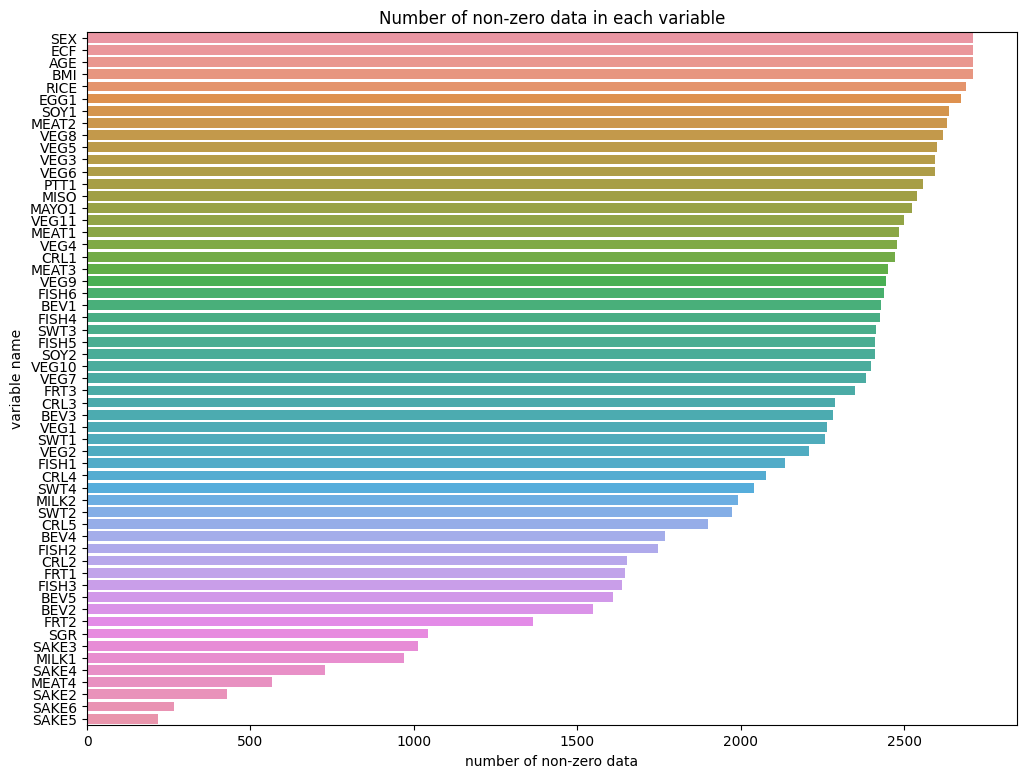

In [25]:
countAvairableVariable(values_dataframe_cleaned)

In [26]:
countZeroData(values_dataframe_cleaned)

SEX         0
ECF         0
AGE         0
BMI         0
RICE       20
EGG1       35
SOY1       73
MEAT2      80
VEG8       90
VEG5      109
VEG3      114
VEG6      116
PTT1      152
MISO      170
MAYO1     186
VEG11     211
MEAT1     226
VEG4      231
CRL1      237
MEAT3     258
VEG9      266
FISH6     273
BEV1      281
FISH4     284
SWT3      296
FISH5     298
SOY2      299
VEG10     310
VEG7      327
FRT3      361
CRL3      420
BEV3      427
VEG1      446
SWT1      451
VEG2      502
FISH1     575
CRL4      633
SWT4      669
MILK2     718
SWT2      738
CRL5      811
BEV4      942
FISH2     964
CRL2     1059
FRT1     1063
FISH3    1073
BEV5     1101
BEV2     1162
FRT2     1346
SGR      1667
SAKE3    1698
MILK1    1741
SAKE4    1983
MEAT4    2143
SAKE2    2281
SAKE6    2444
SAKE5    2494
dtype: int64


In [27]:
# 相関行列を確認
corrMatrix(values_dataframe_cleaned)

('VEG3', 'VEG5', 0.5111778005695479)
('VEG5', 'VEG3', 0.5111778005695479)
('VEG5', 'VEG6', 0.5423405377044409)
('VEG5', 'VEG7', 0.5130633464363883)
('VEG6', 'VEG5', 0.5423405377044409)
('VEG6', 'VEG8', 0.5394437595174767)
('VEG7', 'VEG5', 0.5130633464363883)
('VEG8', 'VEG6', 0.5394437595174767)
('RICE', 'MISO', 0.5631280489864002)
('MISO', 'RICE', 0.5631280489864002)


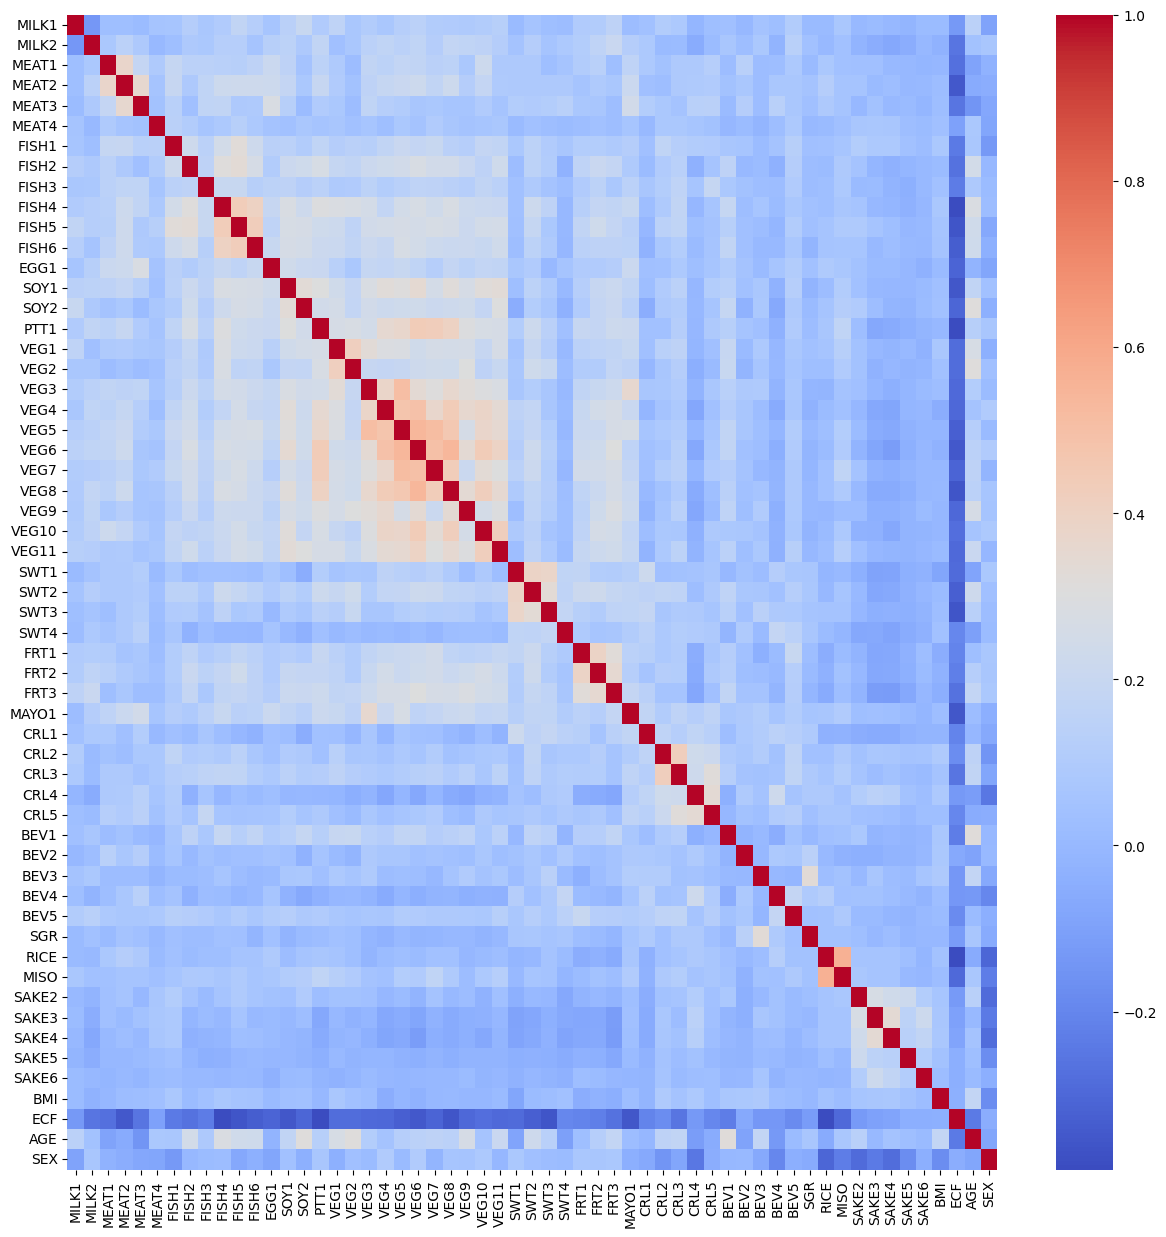

In [28]:
# ヒートマップ確認
heatMap(values_dataframe_cleaned)

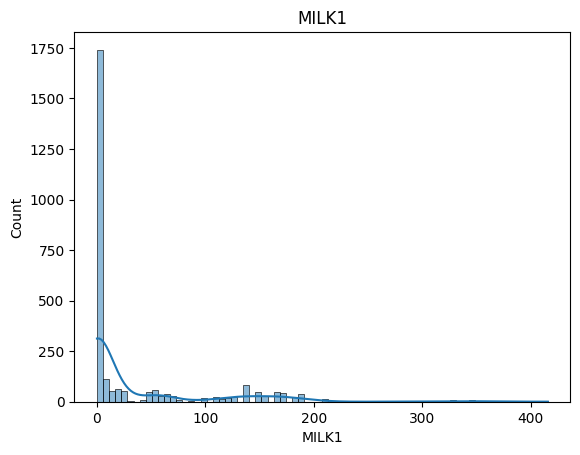

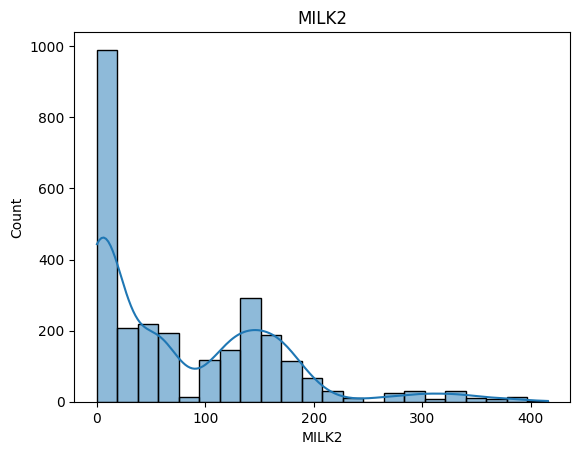

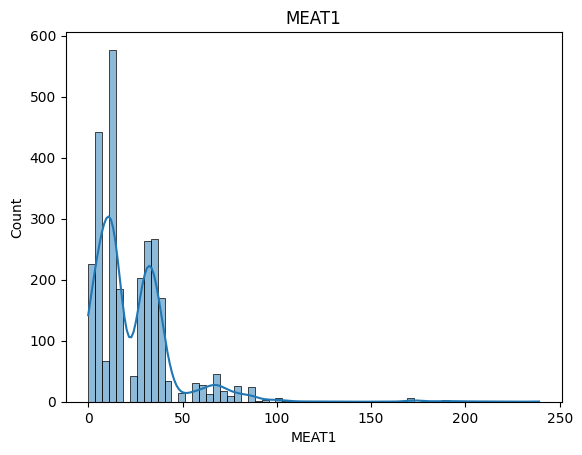

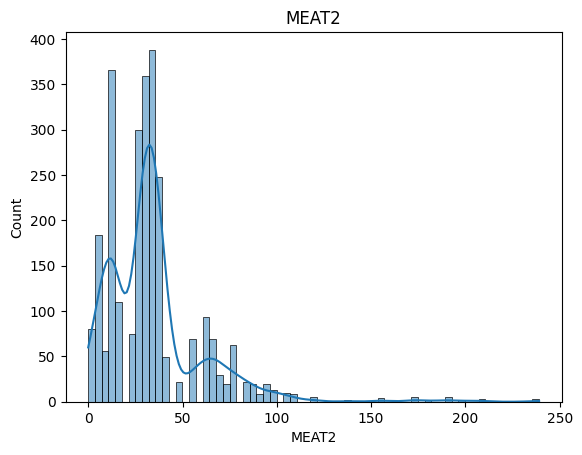

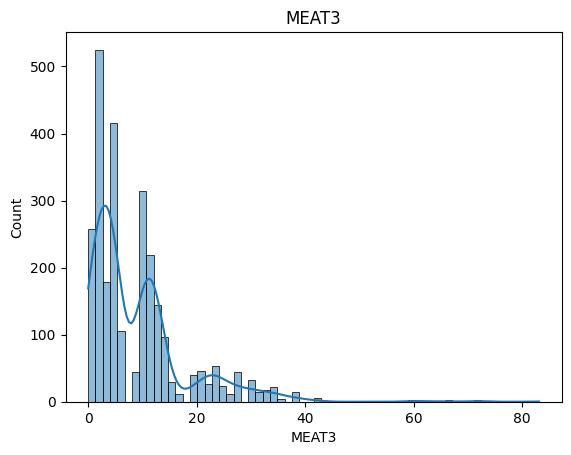

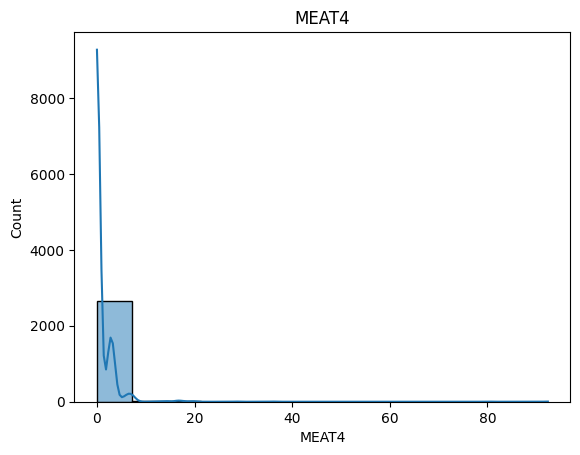

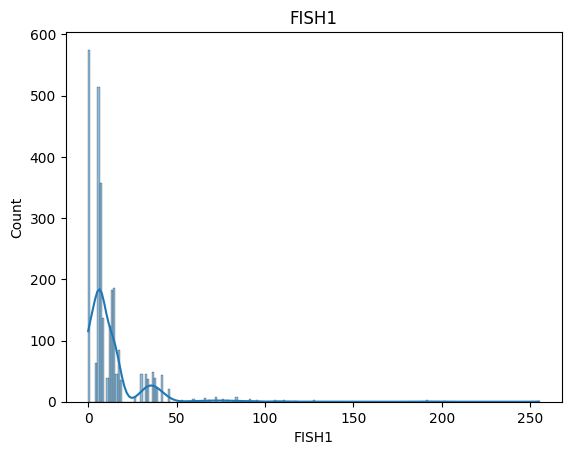

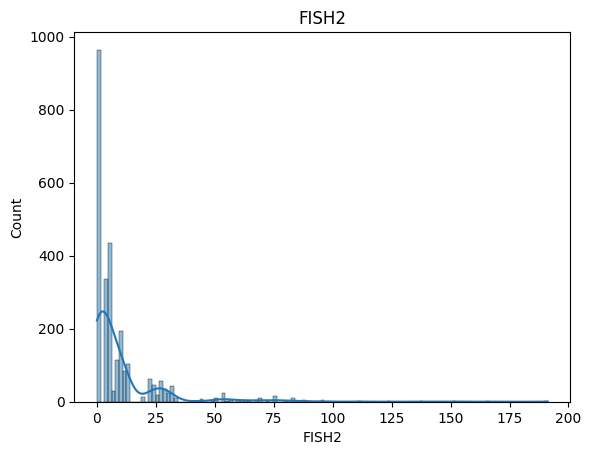

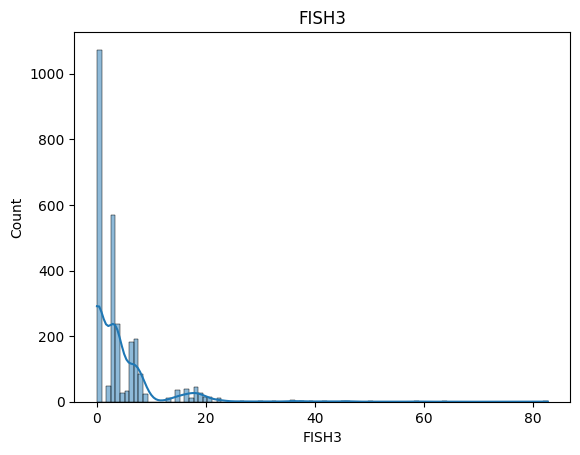

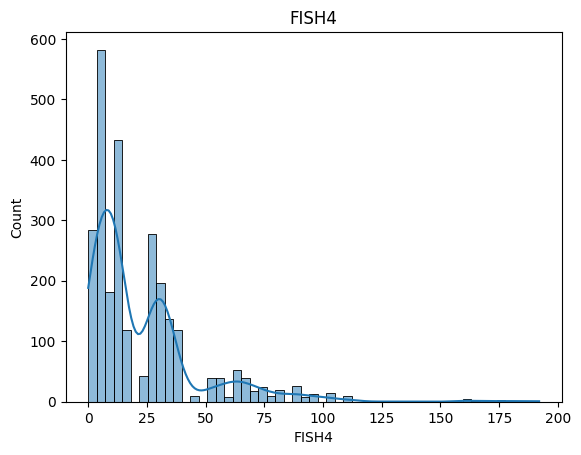

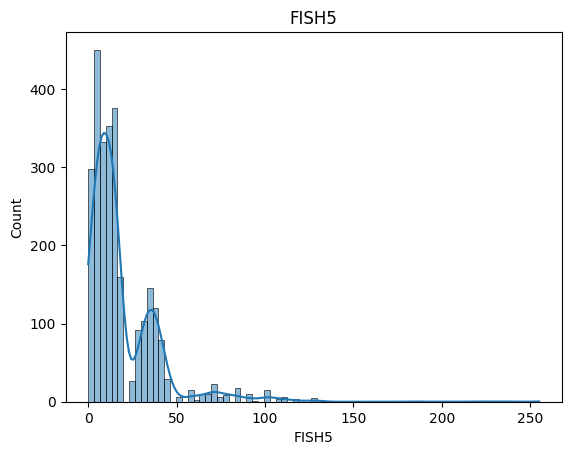

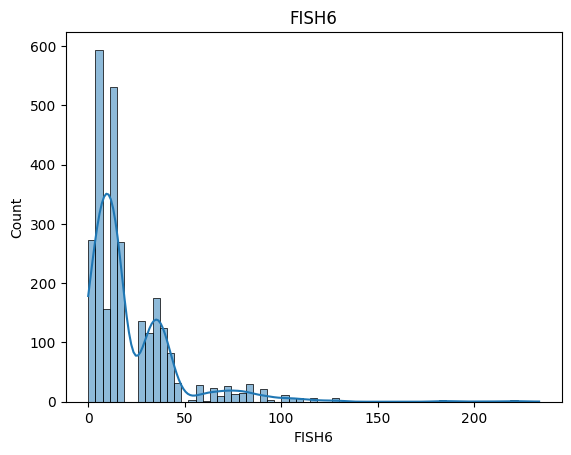

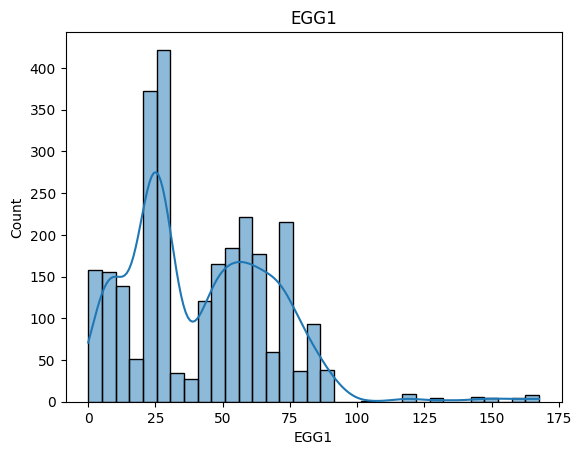

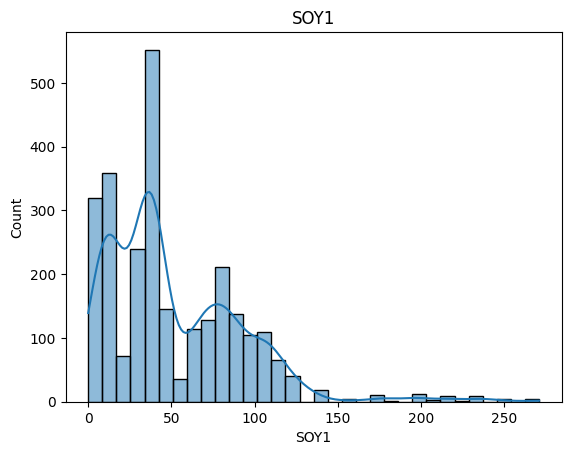

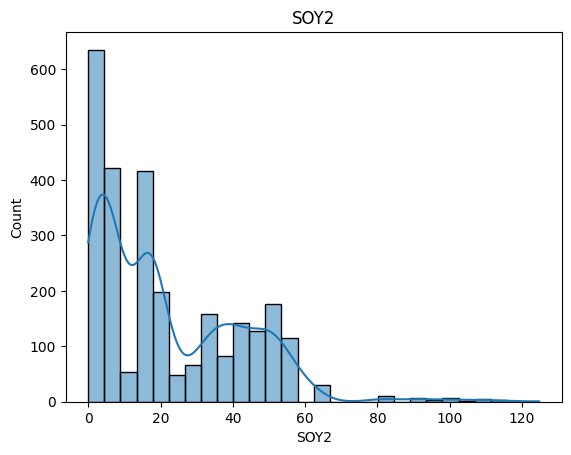

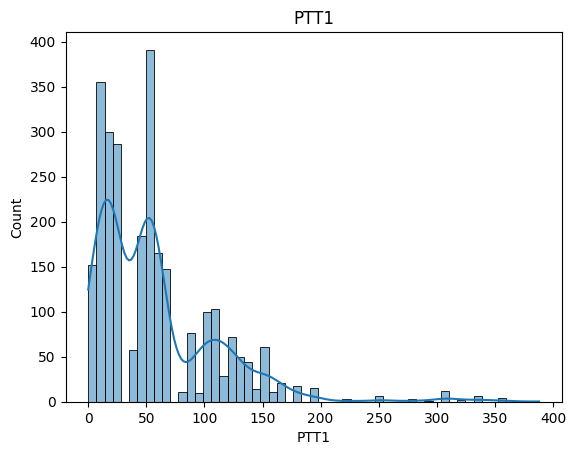

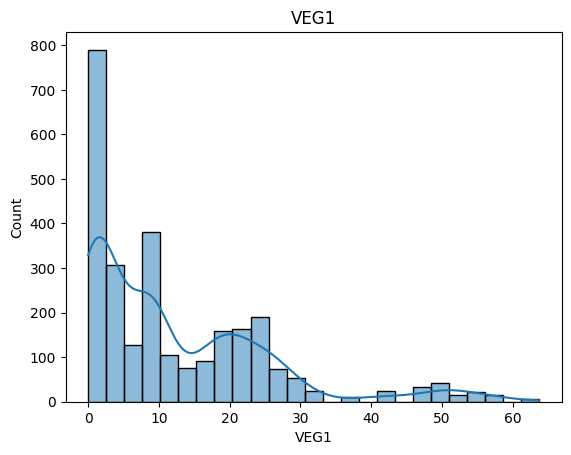

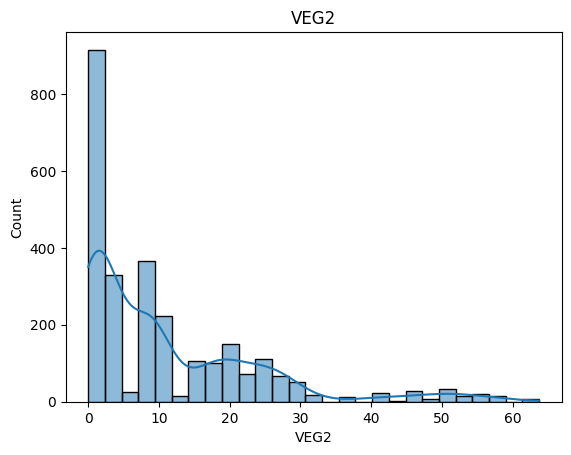

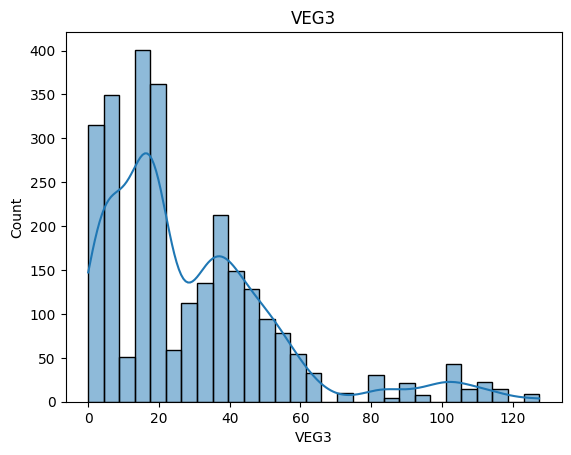

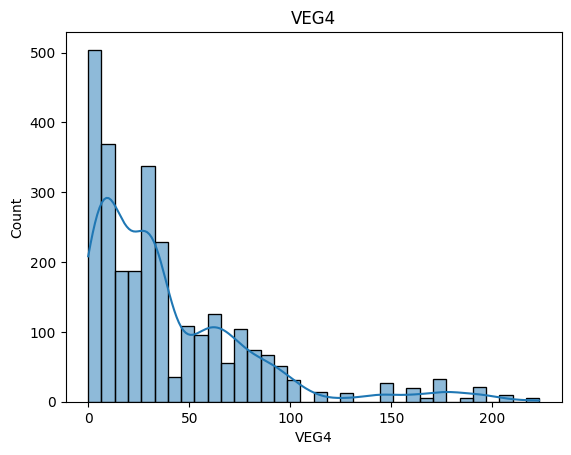

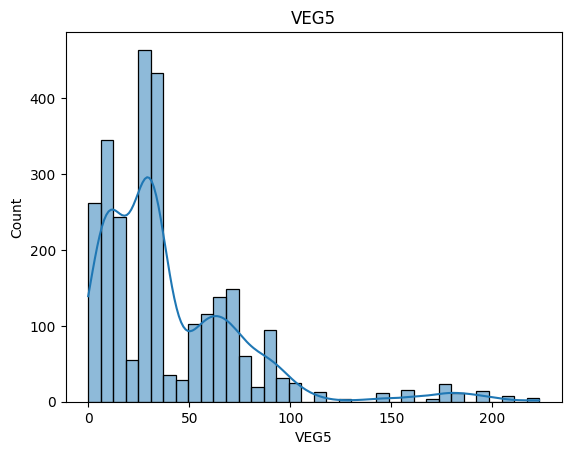

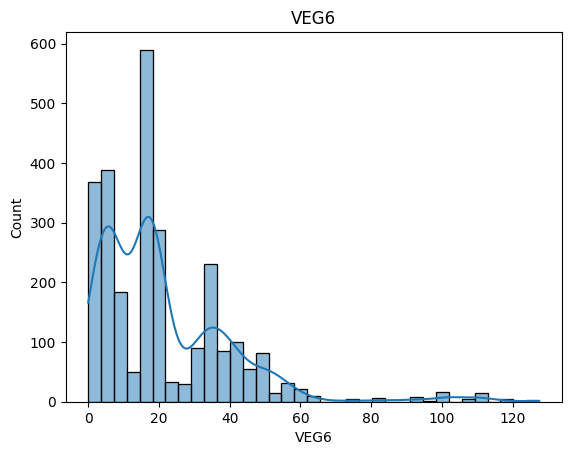

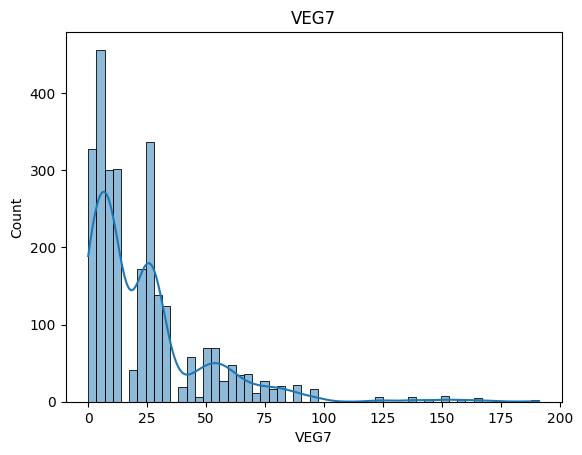

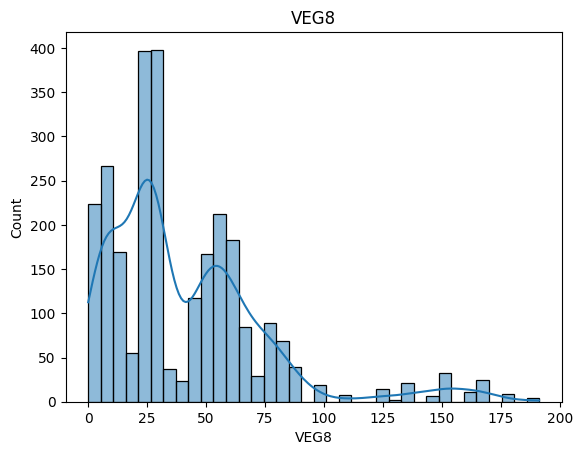

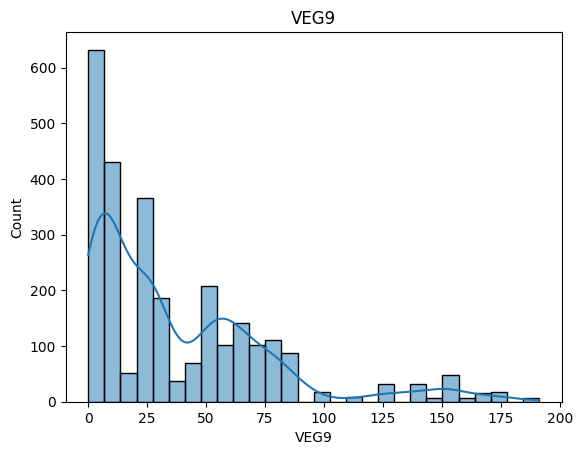

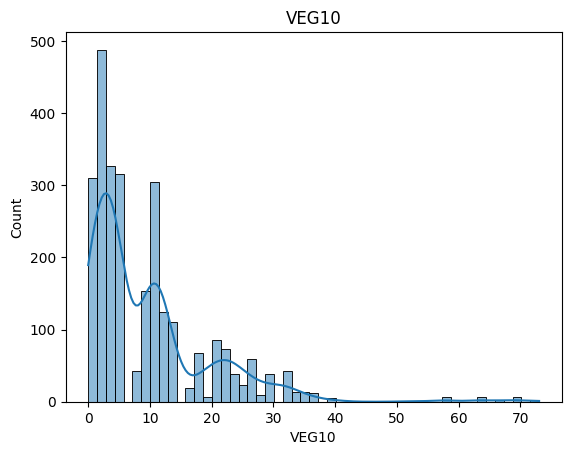

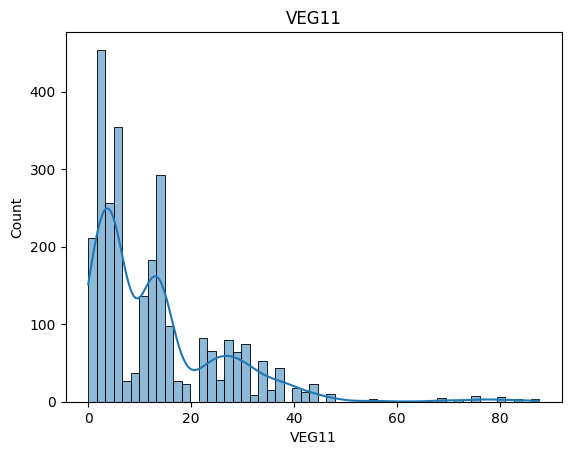

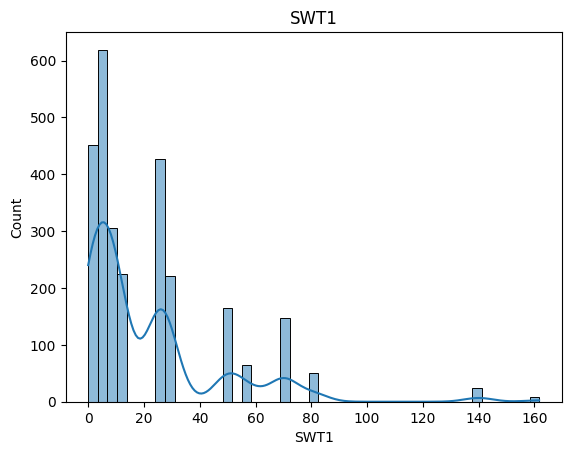

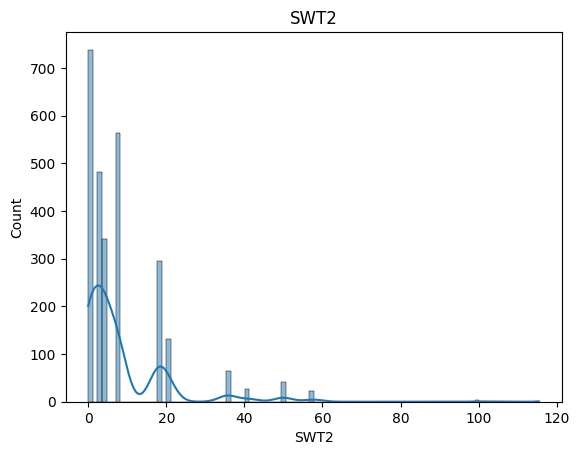

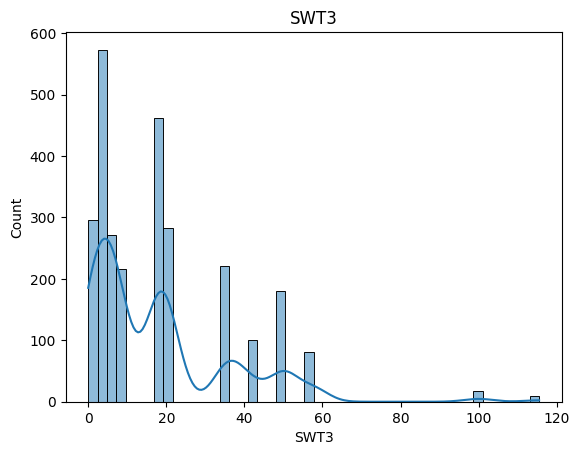

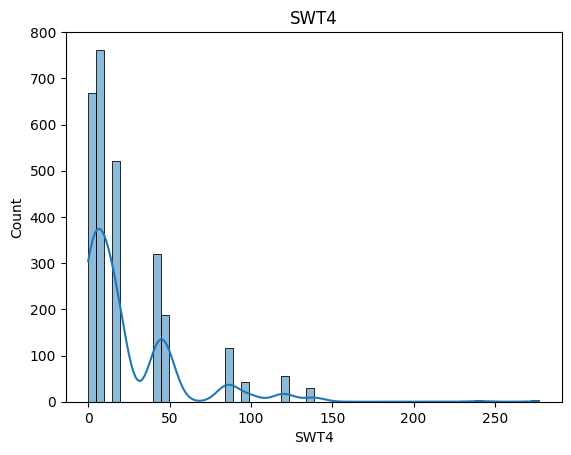

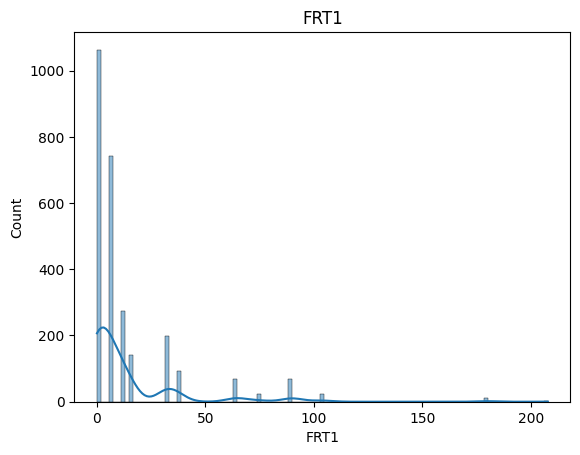

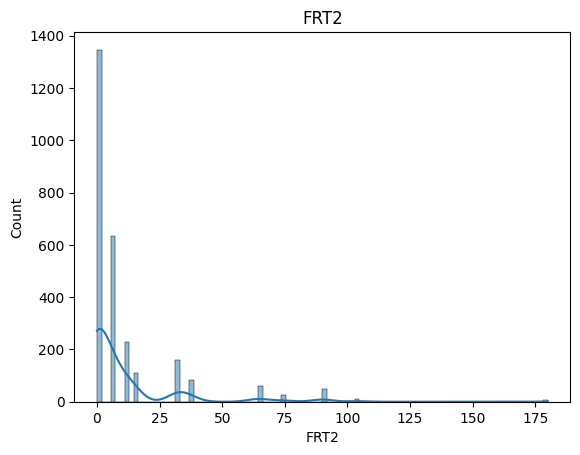

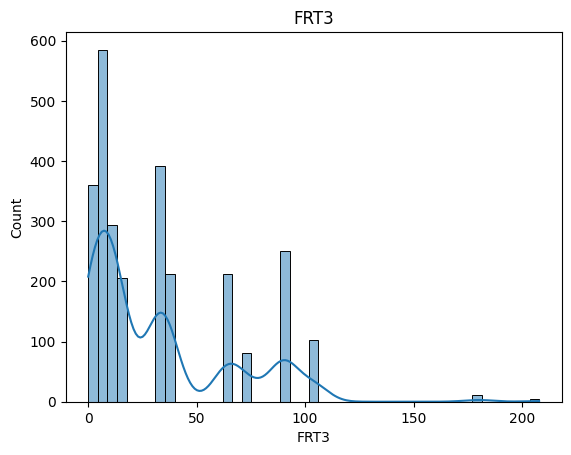

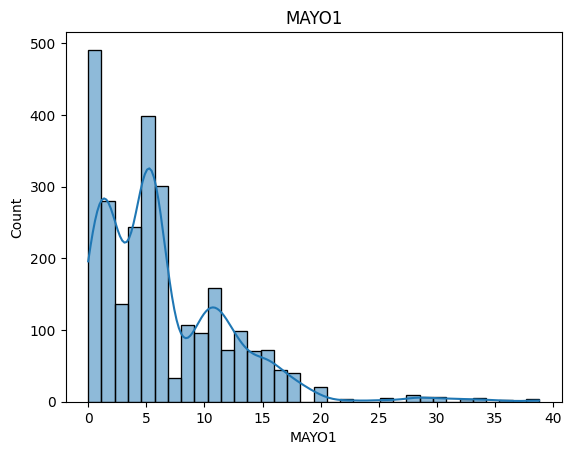

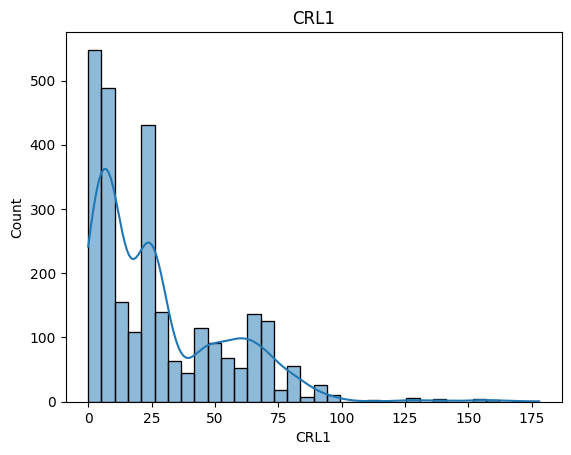

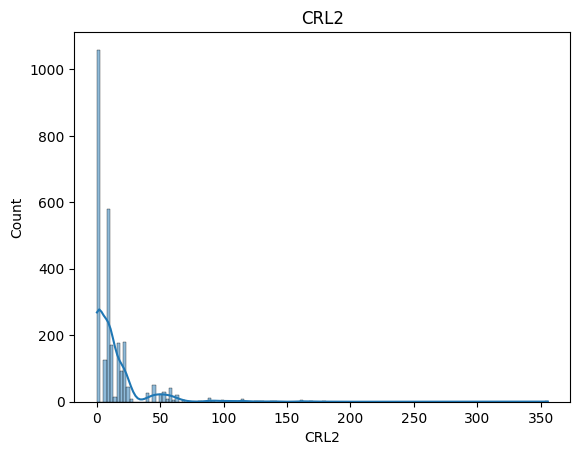

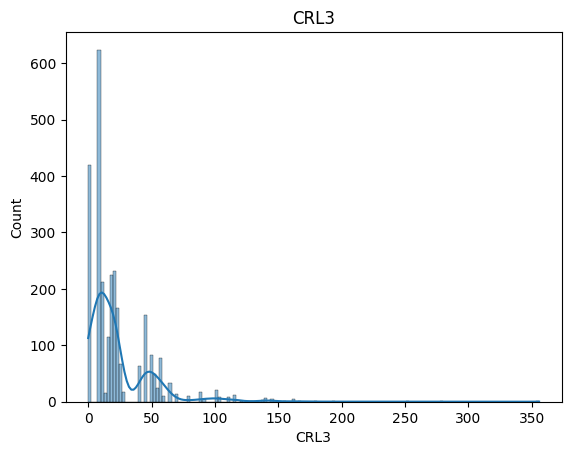

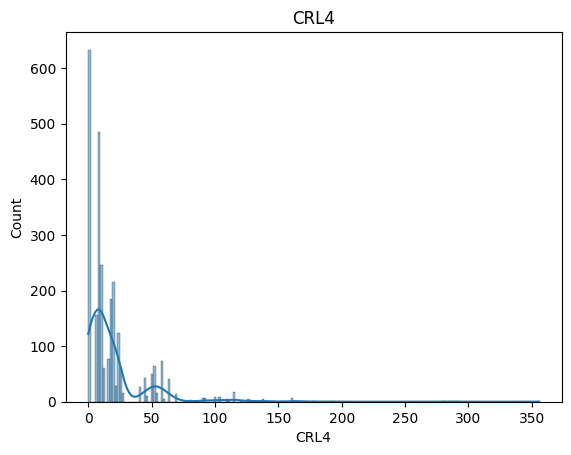

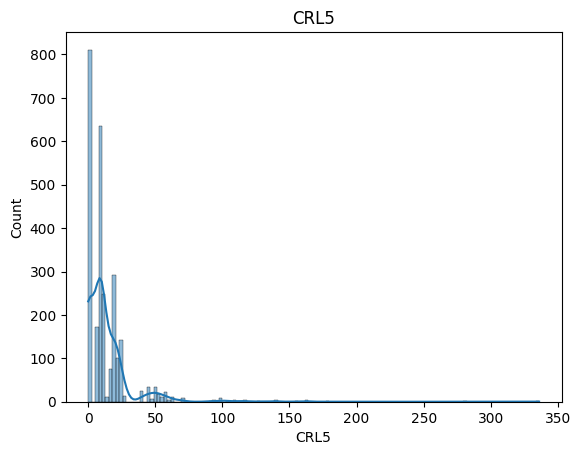

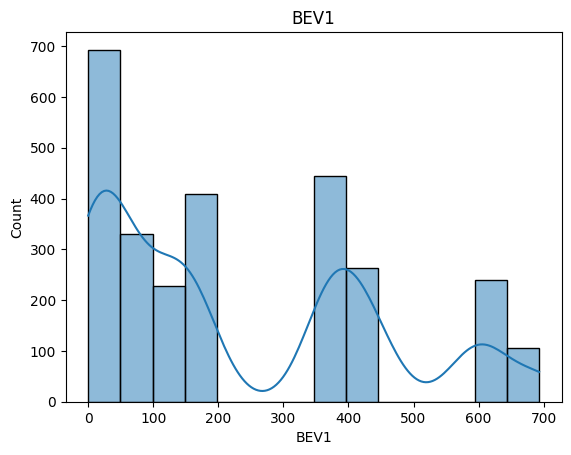

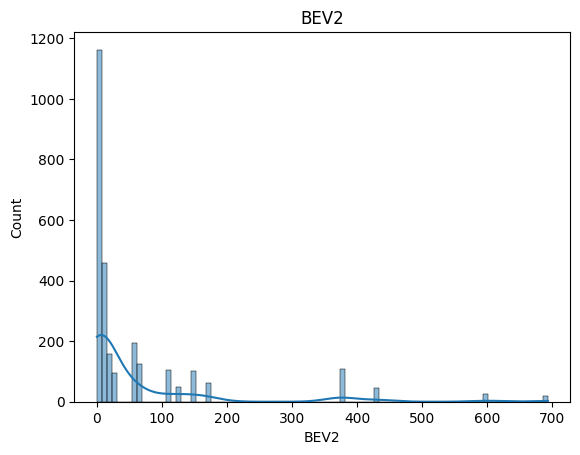

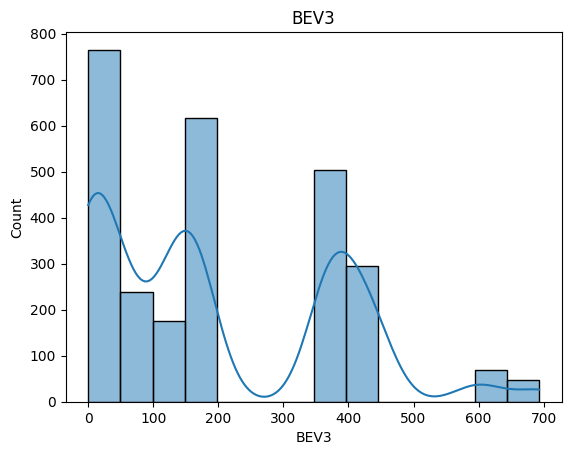

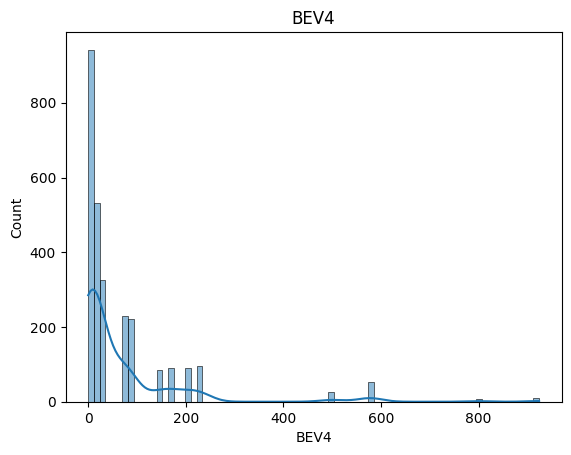

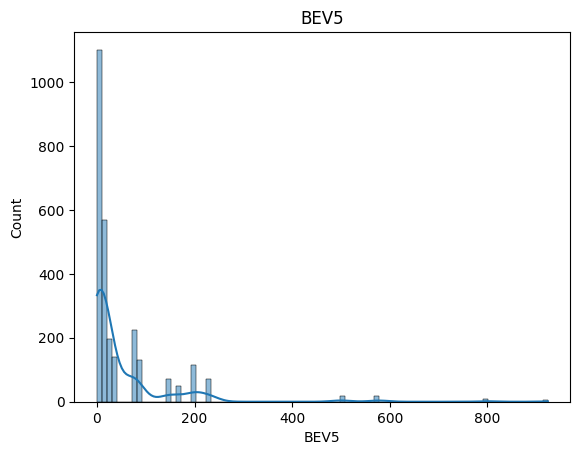

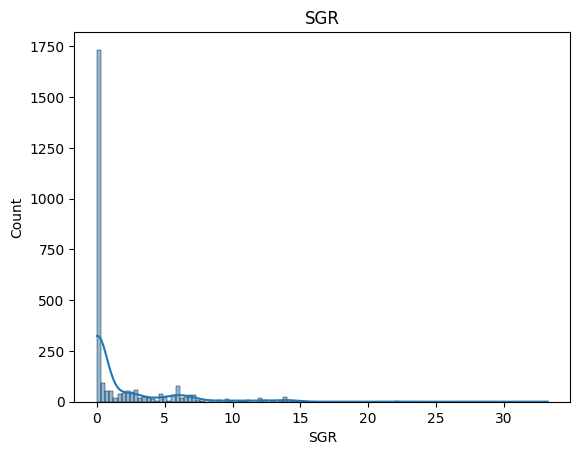

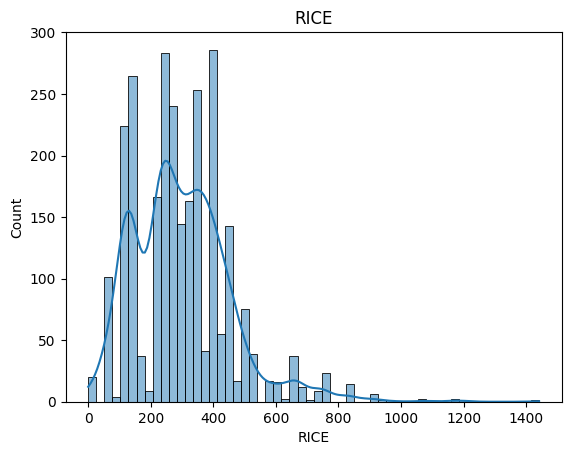

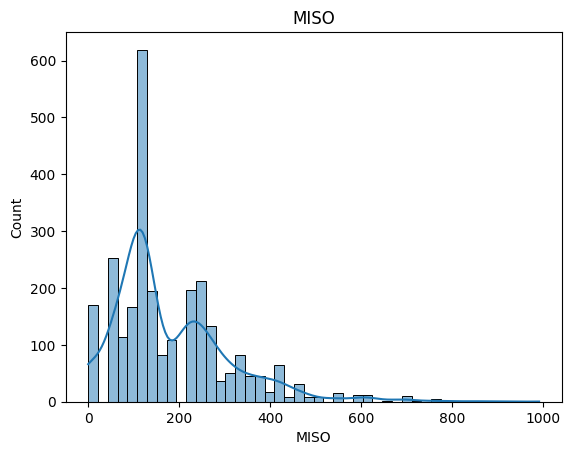

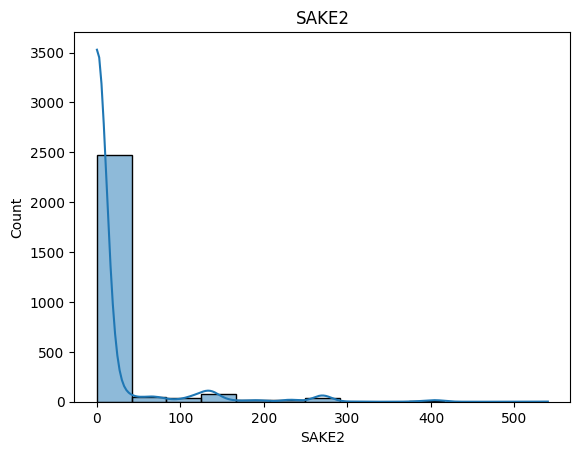

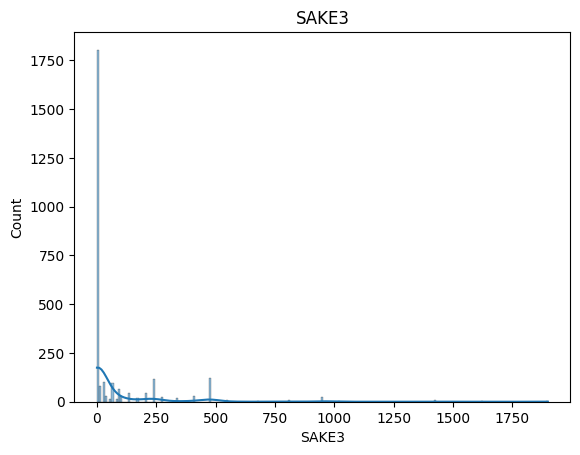

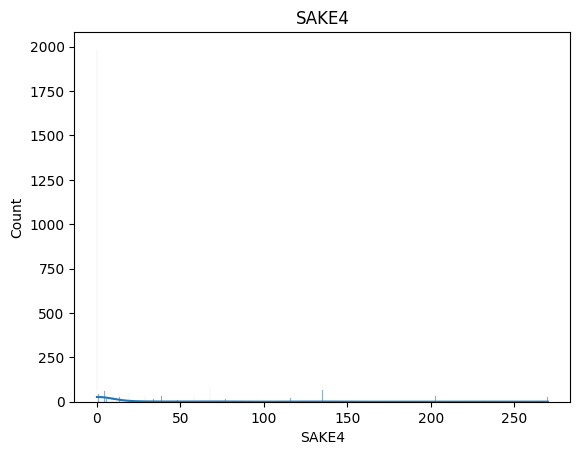

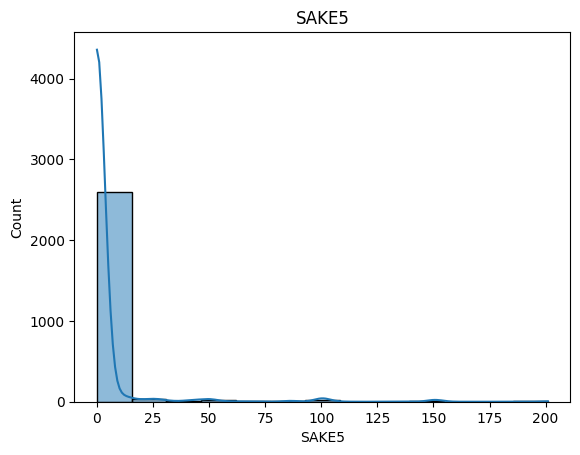

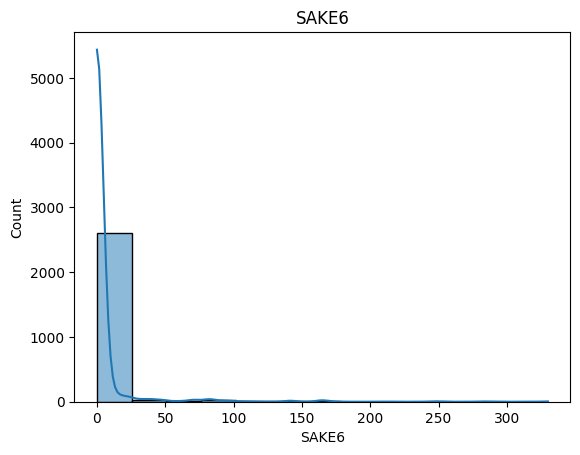

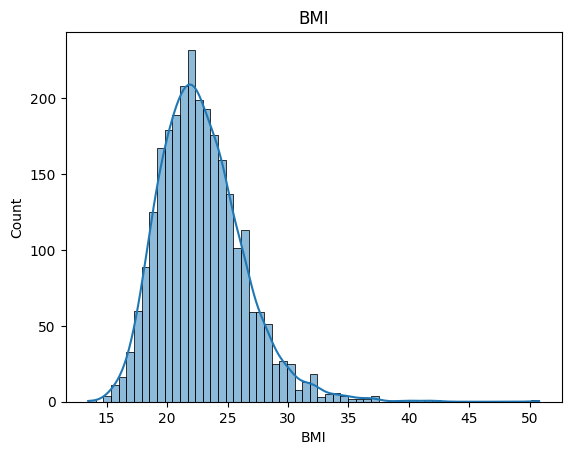

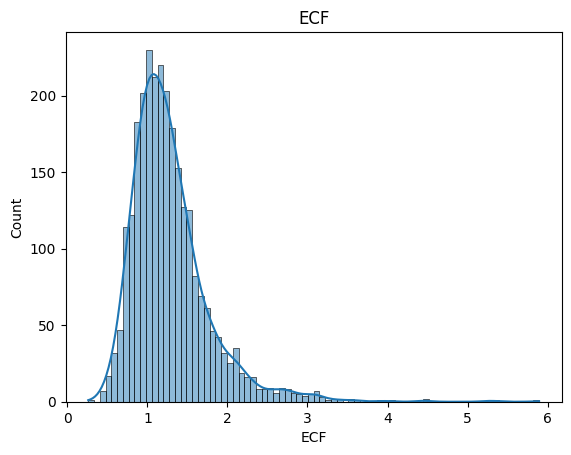

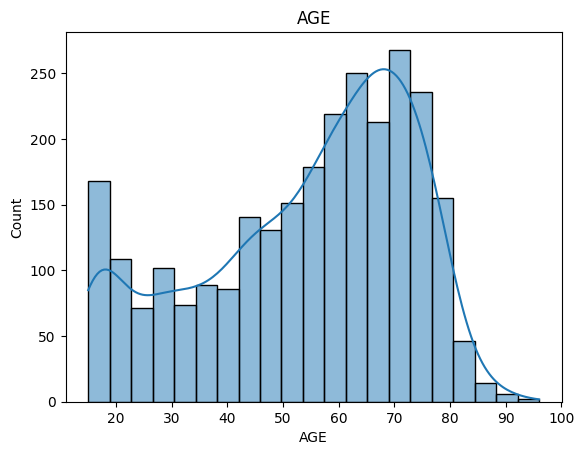

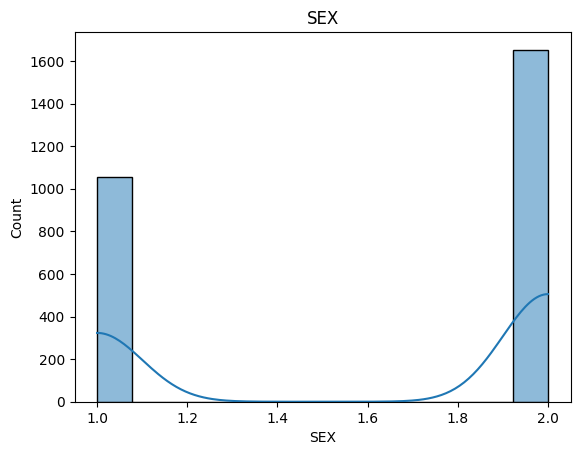

In [29]:
distribution(values_dataframe_cleaned)

### ↑変数作成、欠損処理

### ↓異常値の処理、補正係数処理

In [30]:
# 性別に基づいてデータフレームを分割
male_df = values_dataframe_cleaned[values_dataframe_cleaned['SEX'] == 1]
female_df = values_dataframe_cleaned[values_dataframe_cleaned['SEX'] == 2]

In [31]:
print(len(male_df),len(female_df))

1057 1653


In [32]:
# 年齢の区切り
bins = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# 男性の世代別データフレーム
male_dfs = {}
for i in range(len(bins)-1):
    age_range = f"{bins[i]}s"
    male_dfs[age_range] = male_df[(male_df['AGE'] >= bins[i]) & (male_df['AGE'] < bins[i+1])]

# 女性の世代別データフレーム
female_dfs = {}
for i in range(len(bins)-1):
    age_range = f"{bins[i]}s"
    female_dfs[age_range] = female_df[(female_df['AGE'] >= bins[i]) & (female_df['AGE'] < bins[i+1])]


In [33]:
# 男性の各年齢層のデータ数を出力
print("男性の各年齢層のデータ数:")
for age_range, df in male_dfs.items():
    print(f"{age_range}: {df.shape[0]}")

# 女性の各年齢層のデータ数を出力
print("\n女性の各年齢層のデータ数:")
for age_range, df in female_dfs.items():
    print(f"{age_range}: {len(df)}")

男性の各年齢層のデータ数:
10s: 57
20s: 63
30s: 89
40s: 134
50s: 173
60s: 252
70s: 261
80s: 27

女性の各年齢層のデータ数:
10s: 150
20s: 149
30s: 128
40s: 201
50s: 275
60s: 380
70s: 315
80s: 50
